In [1]:
import numpy as np
import EI_subspace_RNN
import scipy.stats as stats
import scipy.linalg
from utils import *
from plotting_utils import *
import matplotlib.pyplot as plt
colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen', 'olive']

# hyperparameters
N_e = 100
N_i = N_e
N = N_e + N_i
D = 30
sparsity = 0.25
U = 500
T = 100
N_weights = int (N * N * sparsity)
max_iter=30

zeta_alpha_beta_gamma_list = [(10**i,1,1,10**(i-2.5)) for i in list(np.arange(-1.5,0.5,0.25))]

In [2]:
# colormap = ['tab:green','tab:blue','tab:red','tab:brown']
# fig, axes = plt.subplots(1, figsize=(14,6))
# i = 0
# for distr in ['normal']:
#     K = 10
#     n_sim = 5000
#     norm_A = np.zeros((n_sim))
#     nonnormality_A = np.zeros((n_sim))
#     for sim in range(n_sim):
#         eig = generate_eigenvalues(K=10)
#         A, norm_A[sim], nonnormality_A[sim] = generate_dynamics_A(eigenvalues=eig, normal=False)

#     # axes[0].hist(norm_A, color=colormap[i], label=distr, alpha=0.4, bins=20)
#     axes.hist(nonnormality_A, color=colormap[i], label=distr, alpha=0.4, bins=20)

#     i+= 1
# # axes[0].legend()
# # axes.set_ylim(0,100)
# axes.legend()

In [3]:
K_values = [1,2,3,5]#,15,25] 
K_vals = [1,2,3,5]
color_dict = {1:'tab:purple',2:'tab:pink',3:'tab:cyan',5:'yellowgreen', 15:'olive', 25:'tab:brown'}
color_dict_j = {0:'gold',1:'tab:red',2:'tab:orange'}
j_values = [0,1,2]
j_vals = [0]
J_possibility_title = np.array(['normal J', 'normal + co-act', 'uniform J'])
num_simulations=50
max_iter=50

In [4]:
def load_data(N, K_values, j_values, num_simulations, parameter='fitW'):
    data_interest = np.empty((len(K_values), len(j_values), num_simulations), dtype=object)
    for k in range(len(K_values)):
        for j in range(len(j_values)):
            for simulation in range(num_simulations):
                data_interest[k, j, simulation] = np.load(f'models/N={N}_K={K_values[k]}_parameters_simulation_{simulation}_J_possibility_{j_values[j]}.npz', allow_pickle=True)[parameter]
    return data_interest



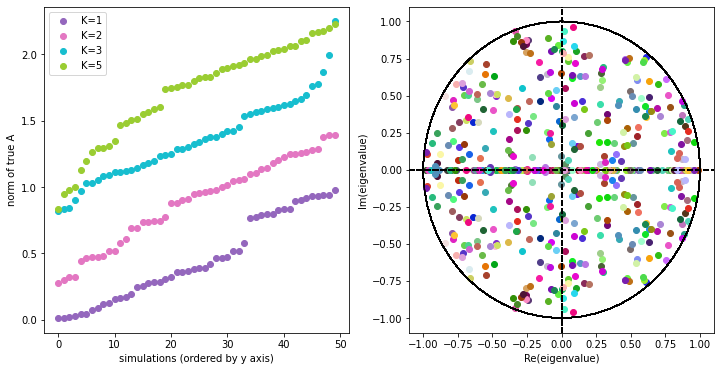

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
def plot_true_A_norm_eig(axes, num_simulations, K_vals=[1]):
    trueA = load_data(N, K_values=K_vals, j_values=[0], num_simulations=num_simulations, parameter='trueA')
    for k in range(len(K_vals)):
        norm_A = np.zeros((num_simulations))
        for simulation in range(norm_A.shape[0]):
            norm_A[simulation] = np.linalg.norm(trueA[k,0,simulation])
            eigval = np.linalg.eigvals(trueA[k,0,simulation])
            plot_eigenvalues(axes[1], eigval, color=generate_random_color(), label='')
        idx = np.argsort(norm_A)
        axes[0].scatter(range(num_simulations), norm_A[idx], color=color_dict.get(K_vals[k]), label=f'K={K_vals[k]}')
        axes[0].set_ylabel('norm of true A')
        axes[0].set_xlabel('simulations (ordered by y axis)')
    axes[0].legend(loc='upper left')

plot_true_A_norm_eig(axes, num_simulations, K_vals=K_vals)
# plt.savefig(f'figures/N={N}_K_values={K_vals}_figure=0_plot_true_A_norm_eig', bbox_inches='tight', dpi=300)
    

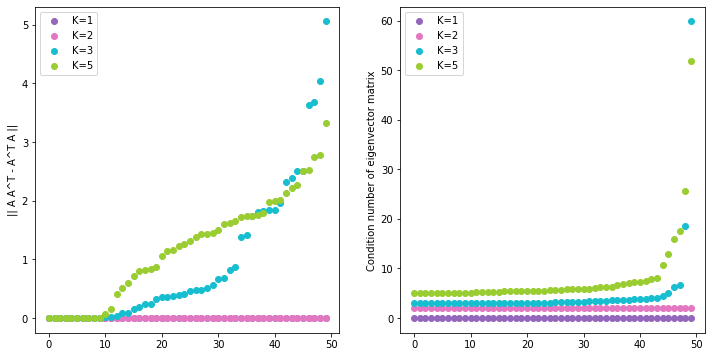

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
def plot_true_A_non_normality(axes, num_simulations, K_vals=[1]):
    trueA = load_data(N, K_values=K_vals, j_values=[0], num_simulations=num_simulations, parameter='trueA')
    for k in range(len(K_vals)):
        non_normality1_A = np.zeros((num_simulations)) # commutator
        non_normality2_A = np.zeros((num_simulations)) # non orthogonality of eigenvectors via condition number
        for simulation in range(non_normality1_A.shape[0]):
            non_normality1_A[simulation] = np.linalg.norm(trueA[k,0,simulation] @ np.transpose(trueA[k,0,simulation]) - np.transpose(trueA[k,0,simulation]) @ trueA[k,0,simulation]) 
            if K_vals[k] != 1:
                _, eigvec = np.linalg.eig(trueA[k,0,simulation])
                non_normality2_A[simulation] = np.linalg.norm(eigvec) * np.linalg.norm(np.linalg.inv(eigvec))
        idx = np.argsort(non_normality1_A)
        axes[0].scatter(range(num_simulations), non_normality1_A[idx], color=color_dict.get(K_vals[k]), label=f'K={K_vals[k]}')
        axes[0].set_ylabel('|| A A^T - A^T A ||')
        idx = np.argsort(non_normality2_A)
        axes[1].scatter(range(num_simulations), non_normality2_A[idx], color=color_dict.get(K_vals[k]), label=f'K={K_vals[k]}')
        axes[1].set_ylabel('Condition number of eigenvector matrix')
        axes[0].legend(loc='upper left')
        axes[1].legend(loc='upper left')

plot_true_A_non_normality(axes, num_simulations, K_vals=K_vals)
# plt.savefig(f'figures/N={N}_K_values={K_vals}_figure=0_plot_true_A_non_normality', bbox_inches='tight', dpi=300)
    


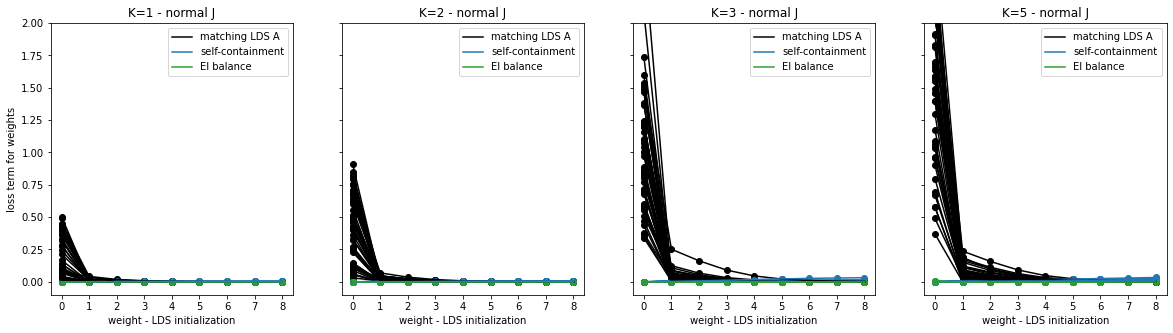

In [7]:
def plot_initialization_loss(axes, num_simulations, K_vals, j_values, zeta_alpha_beta_gamma_list):
    loss_W = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='loss_W')

    # Ensure axes is a 2D array for consistent indexing
    if len(K_vals) == 1 and len(j_values) == 1:
        axes = np.array([[axes]])  # Single subplot
    elif len(K_vals) == 1 or len(j_values) == 1:
        axes = axes.reshape((len(j_values), len(K_vals)))

    for k in range(len(K_vals)):
        for j in range(len(j_values)):
            for simulation in range(num_simulations):
                if simulation == 0:
                    axes[j,k].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,0], color='black', label='matching LDS A')
                    axes[j,k].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,0], color='black')
                    axes[j,k].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,1], color='tab:blue', label='self-containment')
                    axes[j,k].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,1], color='tab:blue')
                    axes[j,k].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,2], color='tab:green', label='EI balance')
                    axes[j,k].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,2], color='tab:green')
                else:
                    axes[j,k].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,0], color='black')
                    axes[j,k].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,0], color='black')
                    axes[j,k].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,1], color='tab:blue')
                    axes[j,k].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,1], color='tab:blue')
                    axes[j,k].plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,2], color='tab:green')
                    axes[j,k].scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[k,j,simulation][:,2], color='tab:green')

                axes[j,k].set_xlabel('weight - LDS initialization')
                axes[j,k].set_xticks(range(loss_W[k,j,simulation][:,0].shape[0]),range(loss_W[k,j,simulation][:,0].shape[0]))
                axes[j,k].legend(loc='upper right')
                axes[j,k].set_title(f'J variation {j}')
                axes[j,k].set_title(f'K={K_vals[k]} - ' + J_possibility_title[j_values[j]])

            axes[0,0].set_ylabel('loss term for weights')
            axes[0,0].set_ylim(-0.1,2)
fig, axes = plt.subplots(len(j_vals), len(K_vals), figsize=(5 * len(K_vals), 5 * len(j_vals)), sharey=True, sharex= True)
# fig, axes = plt.subplots(len(j_vals), len(K_vals), figsize=(5 * len(K_vals), 5 * len(j_vals)), sharey=True, sharex= True)
plot_initialization_loss(axes, num_simulations, K_vals=K_vals, j_values=j_vals, zeta_alpha_beta_gamma_list = zeta_alpha_beta_gamma_list)
# plt.savefig(f'figures/N={N}_K={K}_figure=1_plot_plot_initialization_loss', bbox_inches='tight', dpi=300)



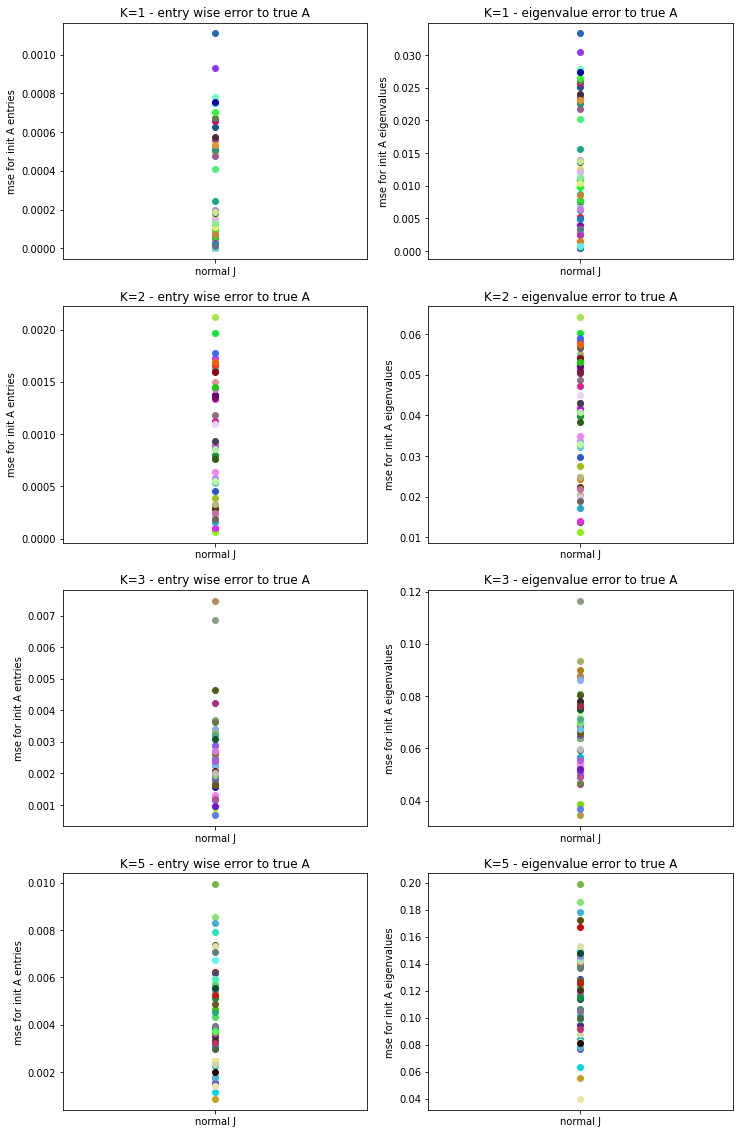

In [8]:
def plot_dynamics_initialization_error(axes, num_simulations, K_vals, j_values=[0,1]):
    J = load_data(N, K_values=K_vals, j_values=j_values, num_simulations=num_simulations, parameter='J')
    trueA = load_data(N, K_values=K_vals, j_values=j_values, num_simulations=num_simulations, parameter='trueA')
    initW = load_data(N, K_values=K_vals, j_values=j_values, num_simulations=num_simulations, parameter='initW')

    if len(K_vals) == 1:
        axes = axes.reshape((len(K_vals), 2))

    for k in range(len(K_vals)):
        for simulation in range(num_simulations):
            color = generate_random_color()
            for j in range(len(j_values)):
                initA = build_dynamics_matrix_A(initW[k,j, simulation], J[k,j, simulation])
                axes[k,0].scatter(j, mse(initA, trueA[k,j, simulation]), color=color)

                eigInit = np.linalg.eigvals(initA)
                eigTrue = np.linalg.eigvals(trueA[k,j,simulation])
                eigDiff = np.abs(eigInit - eigTrue).sum()

                # got to order eigenvalues to best match each other and do a different metric
                axes[k,1].scatter(j, eigDiff, color=color)

                axes[k,0].set_xticks(j_values, J_possibility_title[j_values])
                axes[k,1].set_xticks(j_values, J_possibility_title[j_values])
        
            axes[k,0].set_ylabel('mse for init A entries')
            axes[k,1].set_ylabel('mse for init A eigenvalues')
            axes[k,0].set_title(f'K={K_vals[k]} - entry wise error to true A')
            axes[k,1].set_title(f'K={K_vals[k]} - eigenvalue error to true A')
fig, axes = plt.subplots(len(K_vals), 2, figsize=(12, 5 * len(K_vals)))
plot_dynamics_initialization_error(axes, num_simulations, K_vals=K_vals, j_values=j_vals)
# plt.savefig(f'figures/N={N}_K={K}_figure=2_plot_dynamics_initialization_error', bbox_inches='tight', dpi=300)


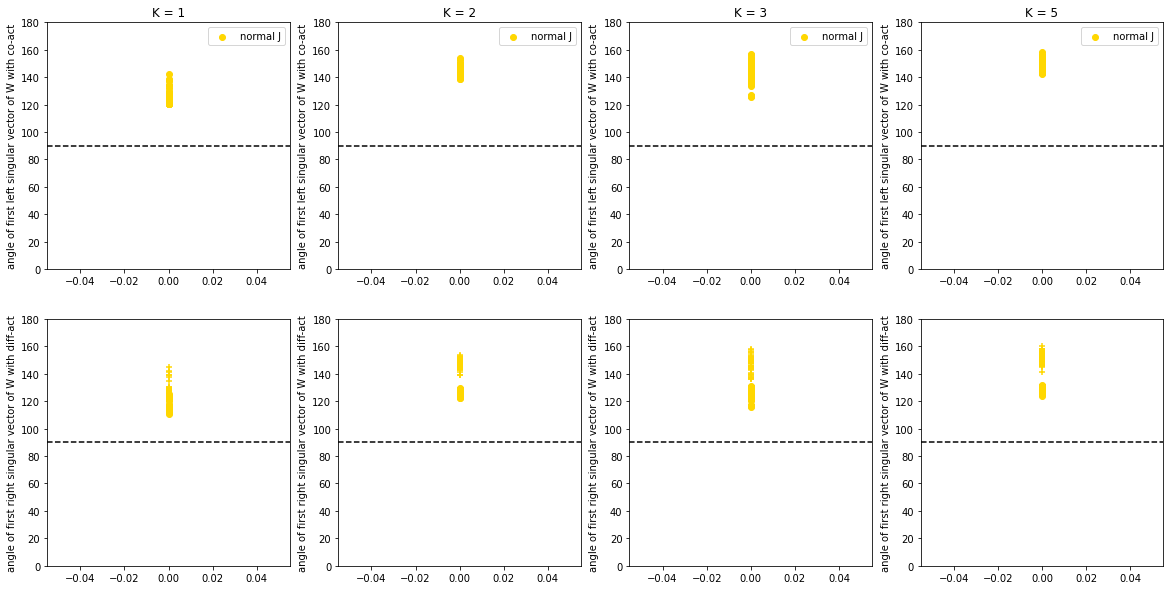

In [9]:
def plot_singular_vectors_W(axes, num_simulations, K_vals=[1], j_values=[0]):
    initW = load_data(N, K_values=K_vals, j_values=j_values, num_simulations=num_simulations, parameter='initW')

    co_act = np.ones((N)) * 1/N ** 0.5
    diff_act1 = np.ones((N))
    diff_act1[N_e:] = 0
    diff_act2 = np.ones((N))
    diff_act2[N_e:] = -1

    for j in range(len(j_values)):
        for k in range(len(K_vals)):
            for simulation in range(num_simulations):
                U, s, Vh = np.linalg.svd(initW[k,j,simulation])
                if simulation == 0:
                    axes[0,k].scatter(j, angle_vectors(co_act, U[:,0]), color=color_dict_j.get(j_values[j]), label=J_possibility_title[j_values[j]])
                    # axes[0,k].scatter(j, angle_vectors(co_act, U[:,0]), color=color_dict_j.get(j_values[j]), label=J_possibility_title[j_values[j]], marker='+')
                    axes[1,k].scatter(j, angle_vectors(diff_act1, Vh[0,:]), color=color_dict_j.get(j_values[j]), label=J_possibility_title[j_values[j]])
                    axes[1,k].scatter(j, angle_vectors(diff_act2, Vh[0,:]), color=color_dict_j.get(j_values[j]), label=J_possibility_title[j_values[j]], marker='+')
                else:
                    axes[0,k].scatter(j, angle_vectors(co_act, U[:,0]), color=color_dict_j.get(j_values[j]))
                    # axes[0,k].scatter(j, angle_vectors(co_act, U[:,1]), color=color_dict_j.get(j_values[j]), marker='+')
                    axes[1,k].scatter(j, angle_vectors(diff_act1, Vh[0,:]), color=color_dict_j.get(j_values[j]))
                    axes[1,k].scatter(j, angle_vectors(diff_act2, Vh[0,:]), color=color_dict_j.get(j_values[j]), label=J_possibility_title[j_values[j]], marker='+')
            # axes[0].scatter(range(num_simulations), norm_W[idx], color=color_dict_j.get(j_values[j]), label=f'j={j_values[j]}')
            axes[0,k].legend()
            axes[0,k].set_ylabel('angle of first left singular vector of W with co-act')
            axes[1,k].set_ylabel('angle of first right singular vector of W with diff-act')
            axes[0,k].set_title(f'K = {K_vals[k]}')
            axes[0,k].axhline(90, color='black',linestyle='dashed')
            axes[1,k].axhline(90, color='black',linestyle='dashed')
            axes[0,k].set_ylim(0,180)
            axes[1,k].set_ylim(0,180)
            # axes[k].set_title(f'Weights init - K = {K_vals[k]}')

fig, axes = plt.subplots(2, len(K_vals), figsize=(5*len(K_vals), 10))
plot_singular_vectors_W(axes, num_simulations, K_vals=K_vals, j_values=j_vals)
# plt.savefig(f'figures/N={N}_K_values={K_vals}_figure=0_plot_true_A_norm_eig', bbox_inches='tight', dpi=300)
    

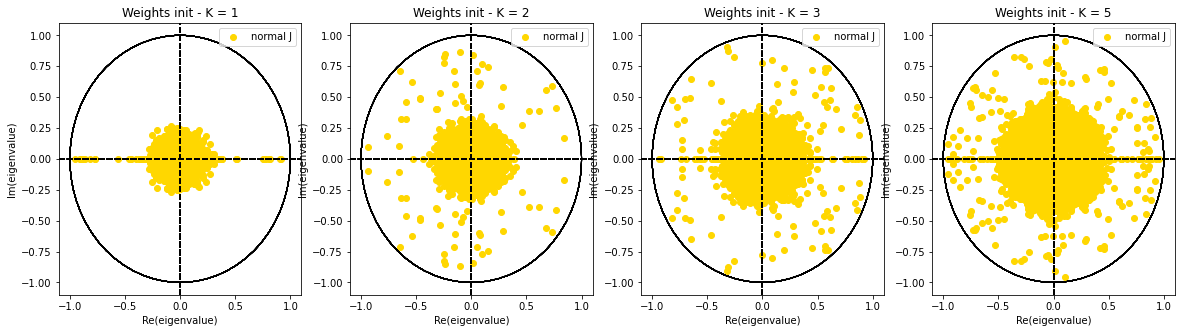

In [10]:
def plot_W_eig(axes, num_simulations, K_vals=[1], j_values=[0]):
    initW = load_data(N, K_values=K_vals, j_values=j_values, num_simulations=num_simulations, parameter='initW')
    for j in range(len(j_values)):
        for k in range(len(K_vals)):
            norm_W = np.zeros((num_simulations))
            for simulation in range(num_simulations):
                norm_W = np.linalg.norm(initW[k,j,simulation])
                eigval = np.linalg.eigvals(initW[k,j,simulation])
                if simulation == 0:
                    plot_eigenvalues(axes[k], eigval,  color=color_dict_j.get(j_values[j]), label=J_possibility_title[j_values[j]])
                else:
                    plot_eigenvalues(axes[k], eigval,  color=color_dict_j.get(j_values[j]))
            idx = np.argsort(norm_W)
            # axes[0].scatter(range(num_simulations), norm_W[idx], color=color_dict_j.get(j_values[j]), label=f'j={j_values[j]}')
            axes[k].legend()
            axes[k].set_title(f'Weights init - K = {K_vals[k]}')

fig, axes = plt.subplots(1, len(K_vals), figsize=(5*len(K_vals), 5))
plot_W_eig(axes, num_simulations, K_vals=K_vals, j_values=j_vals)
# plt.savefig(f'figures/N={N}_K_values={K_vals}_figure=0_plot_true_A_norm_eig', bbox_inches='tight', dpi=300)
    

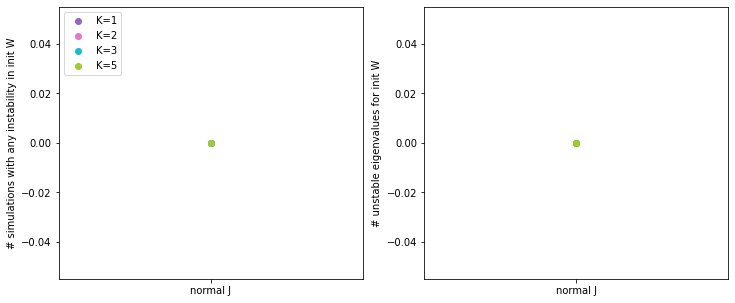

In [11]:
def plot_unstable_initializations(axes, num_simulations, K_vals, j_values=[0,1]):
    initW = load_data(N, K_values=K_vals, j_values=j_values, num_simulations=num_simulations, parameter='initW')
    for k in range(len(K_vals)):
        binary_unstable_init = np.zeros((len(j_values), num_simulations))
        count_unstable_init = np.zeros((len(j_values), num_simulations))

        for simulation in range(num_simulations):
            for j in range(len(j_values)):
                binary_unstable_init[j, simulation], count_unstable_init[j, simulation] = check_unstable(initW[k,j,simulation])
                axes[1].scatter(j, count_unstable_init[j, simulation], color=color_dict.get(K_vals[k]))
            
        axes[0].scatter(j_values, binary_unstable_init.sum(axis=1), color=color_dict.get(K_vals[k]), label=f'K={K_vals[k]}')
        axes[0].set_xticks(j_values, J_possibility_title[j_values])
        axes[1].set_xticks(j_values, J_possibility_title[j_values])
        axes[0].set_ylabel('# simulations with any instability in init W')
        axes[1].set_ylabel('# unstable eigenvalues for init W')
        axes[0].legend(loc='upper left')

fig, axes = plt.subplots(1,2, figsize=(12, 5))
plot_unstable_initializations(axes, num_simulations, K_vals=K_vals, j_values=j_vals)
# plt.savefig(f'figures/N={N}_K={K}_figure=3_plot_unstable_initializations', bbox_inches='tight', dpi=300)




In [12]:
# # whether instability in fitting is solely caused by instability in initialization

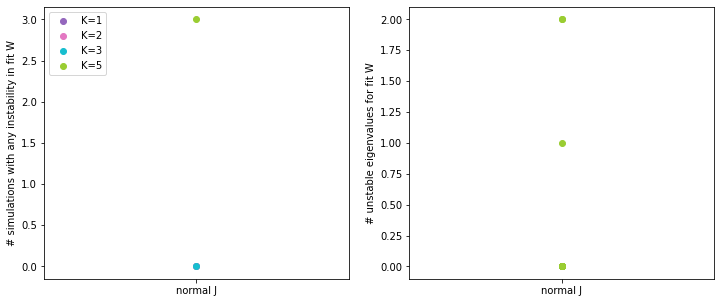

In [13]:
def plot_unstable_fitting(axes, num_simulations, K_vals, j_values=[0,1]):
    fitW = load_data(N, K_values=K_vals, j_values=j_values, num_simulations=num_simulations, parameter='fitW')

    for k in range(len(K_vals)):
        binary_unstable_init = np.zeros((len(j_values), num_simulations))
        count_unstable_init = np.zeros((len(j_values), num_simulations))

        for simulation in range(num_simulations):
            for j in range(len(j_values)):
                
                binary_unstable_init[j, simulation], count_unstable_init[j, simulation] = check_unstable(fitW[k,j,simulation])
                axes[1].scatter(j_values[j], count_unstable_init[j, simulation], color=color_dict.get(K_vals[k]))
            
        axes[0].scatter(j_values, binary_unstable_init.sum(axis=1), color=color_dict.get(K_vals[k]), label=f'K={K_vals[k]}')
        axes[0].set_xticks(j_values, J_possibility_title[j_values])
        axes[1].set_xticks(j_values, J_possibility_title[j_values])
        axes[0].set_ylabel('# simulations with any instability in fit W')
        axes[1].set_ylabel('# unstable eigenvalues for fit W')
        axes[0].legend(loc='upper left')

fig, axes = plt.subplots(1,2, figsize=(12, 5))
plot_unstable_fitting(axes, num_simulations, K_vals=K_vals, j_values=j_vals)
# plt.savefig(f'figures/N={N}_K={K}_figure=3_plot_unstable_initializations', bbox_inches='tight', dpi=300)



# plt.savefig(f'figures/N={N}_K={K}_figure=4_plot_unstable_fitting', bbox_inches='tight', dpi=300)


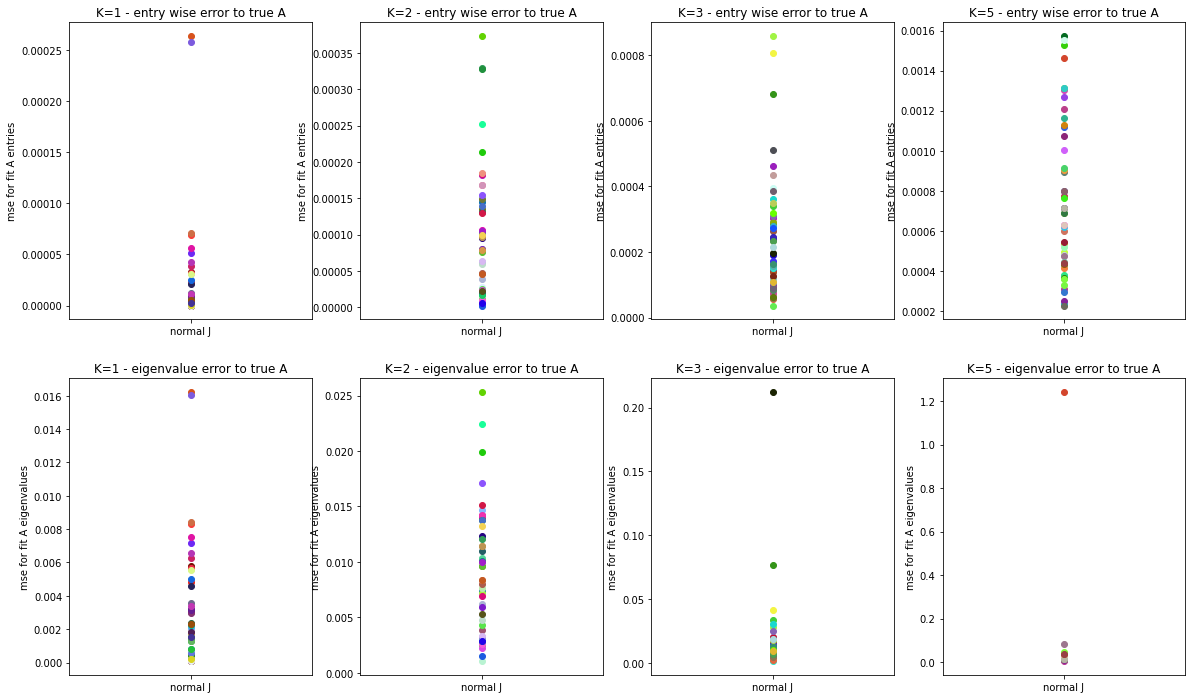

In [14]:
def plot_fit_dynamics_error(axes, num_simulations, K_vals, j_values=[0,1]):
    J = load_data(N, K_values=K_vals, j_values=j_values, num_simulations=num_simulations, parameter='J')
    trueA = load_data(N, K_values=K_vals, j_values=j_values, num_simulations=num_simulations, parameter='trueA')
    initW = load_data(N, K_values=K_vals, j_values=j_values, num_simulations=num_simulations, parameter='fitW')

    if len(K_vals) == 1:
        axes = axes.reshape((2,len(K_vals)))

    for k in range(len(K_vals)):
        for simulation in range(num_simulations):
            color = generate_random_color()
            for j in range(len(j_values)):
                initA = build_dynamics_matrix_A(initW[k,j, simulation], J[k,j, simulation])
                axes[0,k].scatter(j, mse(initA, trueA[k,j, simulation]), color=color)

                eigInit = np.linalg.eigvals(initA)
                eigTrue = np.linalg.eigvals(trueA[k,j,simulation])
                eigDiff = np.abs(eigInit - eigTrue).sum()

                # got to order eigenvalues to best match each other and do a different metric
                axes[1,k].scatter(j, eigDiff, color=color)

                axes[0,k].set_xticks(j_values, J_possibility_title[j_values])
                axes[1,k].set_xticks(j_values, J_possibility_title[j_values])
        
            axes[0,k].set_ylabel('mse for fit A entries')
            axes[1,k].set_ylabel('mse for fit A eigenvalues')
            axes[0,k].set_title(f'K={K_vals[k]} - entry wise error to true A')
            axes[1,k].set_title(f'K={K_vals[k]} - eigenvalue error to true A')
fig, axes = plt.subplots(2, len(K_vals),  figsize=(5 * len(K_vals), 12))
plot_fit_dynamics_error(axes, num_simulations, K_vals, j_values=j_vals)
# plt.savefig(f'figures/N={N}_K={K}_figure=5_plot_fit_dynamics_error', bbox_inches='tight', dpi=300)


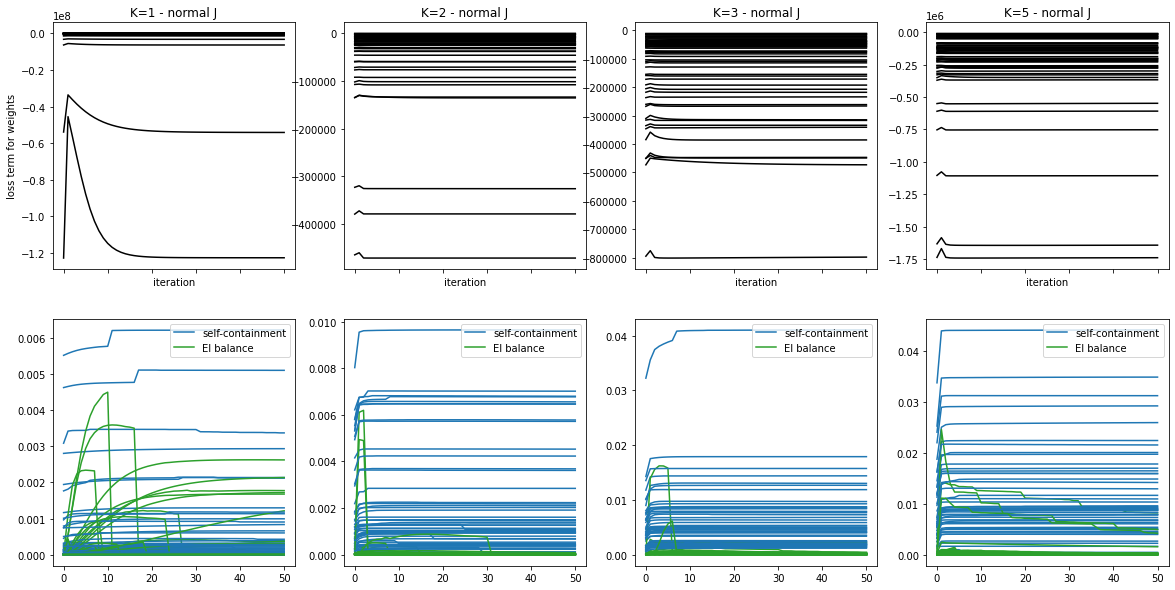

In [15]:
def plot_fitting_loss(axes, max_iter, num_simulations, K_vals, j_values):
    lossW = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='lossW')

    # Ensure axes is a 2D array for consistent indexing
    if len(K_vals) == 1 and len(j_values) == 1:
        axes = np.array([[axes]])  # Single subplot
    elif len(K_vals) == 1 or len(j_values) == 1:
        axes = axes.reshape((2 * len(j_values), len(K_vals)))

    for k in range(len(K_vals)):
        for j in range(len(j_values)):
            for simulation in range(num_simulations):
                if simulation == 0:
                    axes[2*j,k].plot(range(max_iter+1), lossW[k,j,simulation][:,0], color='black', label='matching LDS A')
                    # axes[k,2*j].scatter(range(max_iter+1), lossW[k,j,simulation][:,0], color='black')
                    axes[2*j+1,k].plot(range(max_iter+1), lossW[k,j,simulation][:,1], color='tab:blue', label='self-containment')
                    # axes[k,2*j+1].scatter(range(max_iter+1), lossW[k,j,simulation][:,1], color='tab:blue')
                    axes[2*j+1,k].plot(range(max_iter+1), lossW[k,j,simulation][:,2], color='tab:green', label='EI balance')
                    # axes[k,2*j+1].scatter(range(max_iter+1), lossW[k,j,simulation][:,2], color='tab:green')
                else:
                    axes[2*j,k].plot(range(max_iter+1), lossW[k,j,simulation][:,0], color='black')
                    # axes[k,2*j].scatter(range(max_iter+1), lossW[k,j,simulation][:,0], color='black')
                    axes[2*j+1,k].plot(range(max_iter+1), lossW[k,j,simulation][:,1], color='tab:blue')
                    # axes[k,2*j+1].scatter(range(max_iter+1), lossW[k,j,simulation][:,1], color='tab:blue')
                    axes[2*j+1,k].plot(range(max_iter+1), lossW[k,j,simulation][:,2], color='tab:green')
                    # axes[k,2*j+1].scatter(range(max_iter+1), lossW[k,j,simulation][:,2], color='tab:green')

                axes[2*j,k].set_xlabel('iteration')
                # axes[k,j].set_xticks(range(lossW[k,j,simulation][:,0].shape[0]),range(lossW[k,j,simulation][:,0].shape[0]))
                axes[2*j+1,k].legend(loc='upper right')
                axes[2*j,k].set_title(f'J variation {j}')
                axes[2*j,k].set_title(f'K={K_vals[k]} - ' + J_possibility_title[j_values[j]])
                

            axes[0,0].set_ylabel('loss term for weights')
            # axes[0,0].set_ylim(-0.1,2)
fig, axes = plt.subplots( 2 * len(j_vals), len(K_vals), figsize=(5 * len(K_vals), 10 * len(j_vals)), sharex= True)
plot_fitting_loss(axes, max_iter, num_simulations, K_vals=K_vals, j_values=j_vals)
# plt.savefig(f'figures/N={N}_K={K}_figure=6_plot_fitting_loss', bbox_inches='tight', dpi=300)




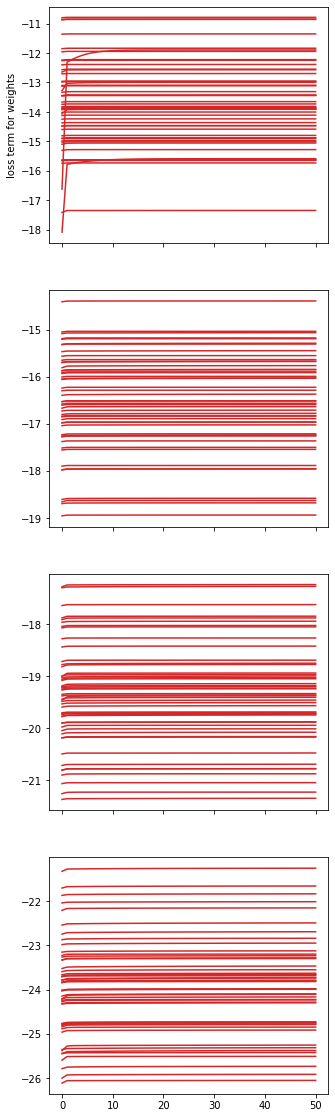

In [16]:
# plot marginal log-likelihood and ECLL terms

def plot_marginal_log_like(axes, max_iter, num_simulations, K_vals, j_values):
    ll = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='ll')
    ecll = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='ll')

    # Ensure axes is a 2D array for consistent indexing
    if len(K_vals) == 1 and len(j_values) == 1:
        axes = np.array([[axes]])  # Single subplot
    elif len(K_vals) == 1 or len(j_values) == 1:
        axes = axes.reshape((len(K_vals)), len(j_values))

    for k in range(len(K_vals)):
        for j in range(len(j_values)):
            for simulation in range(num_simulations):
                if simulation == 0:
                    axes[k,j].plot(range(max_iter+1), (ll[k,j,simulation].sum(axis=1)/(U*T))[:], color='tab:red', label='ll')
                    # axes[k,2*j].scatter(range(max_iter+1), lossW[k,j,simulation][:,0], color='black')
                else:
                    axes[k,j].plot(range(max_iter+1), (ll[k,j,simulation].sum(axis=1)/(U*T))[:], color='tab:red', label='ll')
                    # axes[k,2*j].scatter(range(max_iter+1), lossW[k,j,simulation][:,0], color='black')

                # axes[k,2*j].set_xlabel('weight - LDS initialization')
                # # axes[k,j].set_xticks(range(lossW[k,j,simulation][:,0].shape[0]),range(lossW[k,j,simulation][:,0].shape[0]))
                # axes[k,2*j+1].legend(loc='upper right')
                # axes[k,2*j].set_title(f'J variation {j}')
                # axes[k,2*j].set_title(f'K={K_vals[k]} - ' + J_possibility_title[j_values[j]])

            axes[0,0].set_ylabel('loss term for weights')
            # axes[0,0].set_ylim(-0.1,2)
fig, axes = plt.subplots(len(K_vals), len(j_vals), figsize=(5 * len(j_vals), 5 * len(K_vals)), sharex= True)
plot_marginal_log_like(axes, max_iter, num_simulations, K_vals=K_vals, j_values=j_vals)
# plt.savefig(f'figures/N={N}_K={K}_figure=6_plot_fitting_loss', bbox_inches='tight', dpi=300)




[[-0.0338437   0.00847897  0.01926648 -0.01407647 -0.02952409 -0.02449512
  -0.03404876 -0.00470079 -0.00861034 -0.03554903 -0.03585336 -0.00082577
   0.03024331 -0.03076705  0.00465668 -0.04683171 -0.04886897 -0.01358657
   0.00504319 -0.03011801  0.00200922 -0.04260019  0.01687472  0.03759757
   0.01569348  0.00984528 -0.01075155  0.01727061 -0.02575652 -0.03043203]
 [ 0.00847897 -0.00303988  0.03801279 -0.00524581  0.01947466  0.0096985
  -0.03196556 -0.00671779  0.03783844 -0.02072735 -0.0195781   0.00701135
   0.05384685 -0.04373726  0.04745377 -0.01505635 -0.0200752  -0.00179664
   0.00395122 -0.00137064  0.01074949 -0.01450117  0.06069131  0.00888869
   0.03124786  0.00913629  0.01383028  0.01861834 -0.00829892 -0.02515809]
 [ 0.01926648  0.03801279  0.03140586  0.01377733  0.0031085   0.0245028
   0.00208544  0.00749866  0.02474977  0.01935074 -0.0031144   0.01591928
   0.02679305 -0.01749205  0.03942546  0.00086648 -0.00878872  0.00623825
   0.02174096  0.00737584  0.03730585 

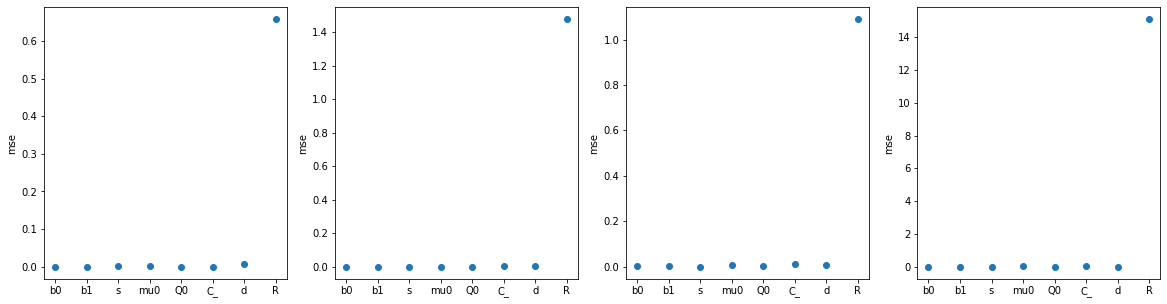

In [24]:
def plot_error_parameters(axes, num_simulations, K_vals, j_values):

    # Ensure axes is a 2D array for consistent indexing
    if len(K_vals) == 1 and len(j_values) == 1:
        axes = np.array([[axes]])  # Single subplot
    elif len(K_vals) == 1 or len(j_values) == 1:
        axes = axes.reshape(( len(j_values), len(K_vals)))

    b = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='b')
    s = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='s')
    mu0 = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='mu0')
    Q0 = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='Q0')
    C_ = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='C_')
    d = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='d')
    R = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='R')
    true_b = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='true_b')
    true_s = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='true_s')
    true_mu0 = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='true_mu0')
    true_Q0 = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='true_Q0')
    true_C_ = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='true_C_')
    true_d = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='true_d')
    true_R = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='true_R')

    for k in range(len(K_vals)):
        for j in range(len(j_values)):
            for simulation in range(num_simulations):
                if simulation == 49:
                    plot_mse_parameters(axes[j,k], b[k,j,simulation].item(), s[k,j,simulation], mu0[k,j,simulation], Q0[k,j,simulation], C_[k,j,simulation], d[k,j,simulation], R[k,j,simulation], true_b[k,j,simulation].item(), true_s[k,j,simulation], true_mu0[k,j,simulation], true_Q0[k,j,simulation], true_C_[k,j,simulation], true_d[k,j,simulation], true_R[k,j,simulation])

                    print((R[k,j,simulation] - true_R[k,j,simulation]))

K_vals = [1,2,3,5]
fig, axes = plt.subplots(len(j_vals),len(K_vals), figsize=(5 * len(K_vals),5 * len(j_vals)), sharex= True)
plot_error_parameters(axes, num_simulations=50, K_vals=K_vals, j_values=j_vals)

# for eig in range(3):
#     fig, axes = plt.subplots(figsize=(5,5))
#     for simulation in range(30):
#         if binary_unstable_init[eig, simulation] == 0 and binary_unstable_fit[eig,simulation] == 0: 
#             plot_mse_parameters(axes, b[eig,simulation].item(), s[eig,simulation], mu0[eig,simulation], Q0[eig,simulation], C_[eig,simulation], d[eig,simulation], R[eig,simulation], true_b[eig,simulation].item(), true_s[eig,simulation], true_mu0[eig,simulation], true_Q0[eig,simulation], true_C_[eig,simulation], true_d[eig,simulation], true_R[eig,simulation])

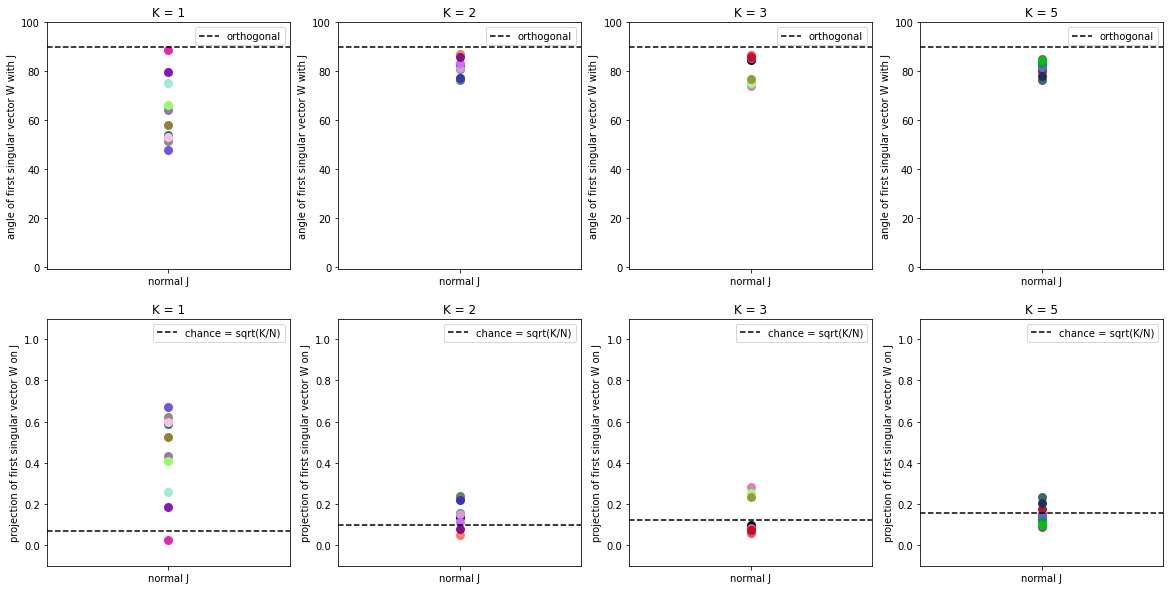

In [18]:
def plot_relationship_W_J(axes, num_simulations, K_vals=[1,2], j_values=[0,1]):
    fitW = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='fitW')
    J = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='J')

    for k in range(len(K_vals)):
        for simulation in range(num_simulations):
            color = generate_random_color()
            for j in range(len(j_values)):
                # ones = np.ones((J[0,0].shape[1]))
                # v_proj, angle = projection_on_subspace(ones, J[j,simulation])
                # axes[0].scatter(j, np.linalg.norm(v_proj)/np.linalg.norm(ones), color='tab:red', label=f'co-activation', linewidth=3)
                
                U, s, Vh = np.linalg.svd(fitW[k,j,simulation])
                v_proj, angle = projection_on_subspace(U[:,0],J[k,j,simulation])
                axes[0,k].scatter(j_values[j], angle, color=color, linewidth=3)
                axes[1,k].scatter(j_values[j], np.linalg.norm(v_proj)/np.linalg.norm(U[:,0]), color=color, linewidth=3)

        axes[0,k].axhline(90, color='black', linestyle='dashed', label='orthogonal')
        axes[1,k].axhline(np.sqrt(K_vals[k]/N), color='black', linestyle='dashed', label='chance = sqrt(K/N)')

        axes[0,k].set_xticks(j_values, J_possibility_title[j_values])
        axes[1,k].set_xticks(j_values, J_possibility_title[j_values])
        axes[0,k].set_ylabel('angle of first singular vector W with J')
        axes[0,k].set_ylim(-1,100)
        axes[1,k].set_ylim(-0.1,1.1)
        axes[1,k].set_ylabel('projection of first singular vector W on J')
        axes[0,k].legend()
        axes[1,k].legend()
        axes[0,k].set_title(f'K = {K_vals[k]}')
        axes[1,k].set_title(f'K = {K_vals[k]}')

fig, axes = plt.subplots(2, len(K_vals), figsize=(5 * len(K_vals), 10))
plot_relationship_W_J(axes, num_simulations=10, K_vals=K_vals, j_values=j_vals)
# plt.savefig(f'figures/N={N}_K={K}_figure=7_plot_relationship_W_J', bbox_inches='tight', dpi=300)


# fig, axes = plt.subplots(figsize=(5,6))
# for k in range(K):
#     v_proj, angle = projection_on_subspace(eigvec_PCA[:,k],J)
#     axes.axhline(np.linalg.norm(v_proj)/np.linalg.norm(eigvec_PCA[:,k]), color=colormap[k], label=f'PCA comp {k+1}', linewidth=3)

# v_proj, angle = projection_on_subspace(ones, J)
# axes.axhline(np.linalg.norm(v_proj)/np.linalg.norm(ones), color='tab:red', label=f'co-activation', linewidth=3)

# v_proj, angle = projection_on_subspace(U[:,0],J)
# axes.axhline(np.linalg.norm(v_proj)/np.linalg.norm(U[:,0]), color='yellow', label=f'first singular vector W', linewidth=3)


# axes.axhline(np.sqrt(K/N), color='black', linestyle='dashed', label='chance = sqrt(K/N)')
# axes.set_ylabel('length of projection on subspace J')
# # axes.set_ylim(0,120)
# axes.set_xticks([],[])
# # axes.set_yticks([0,30,60,90,120],[0,30,60,90,120])
# axes.legend()

0
1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3


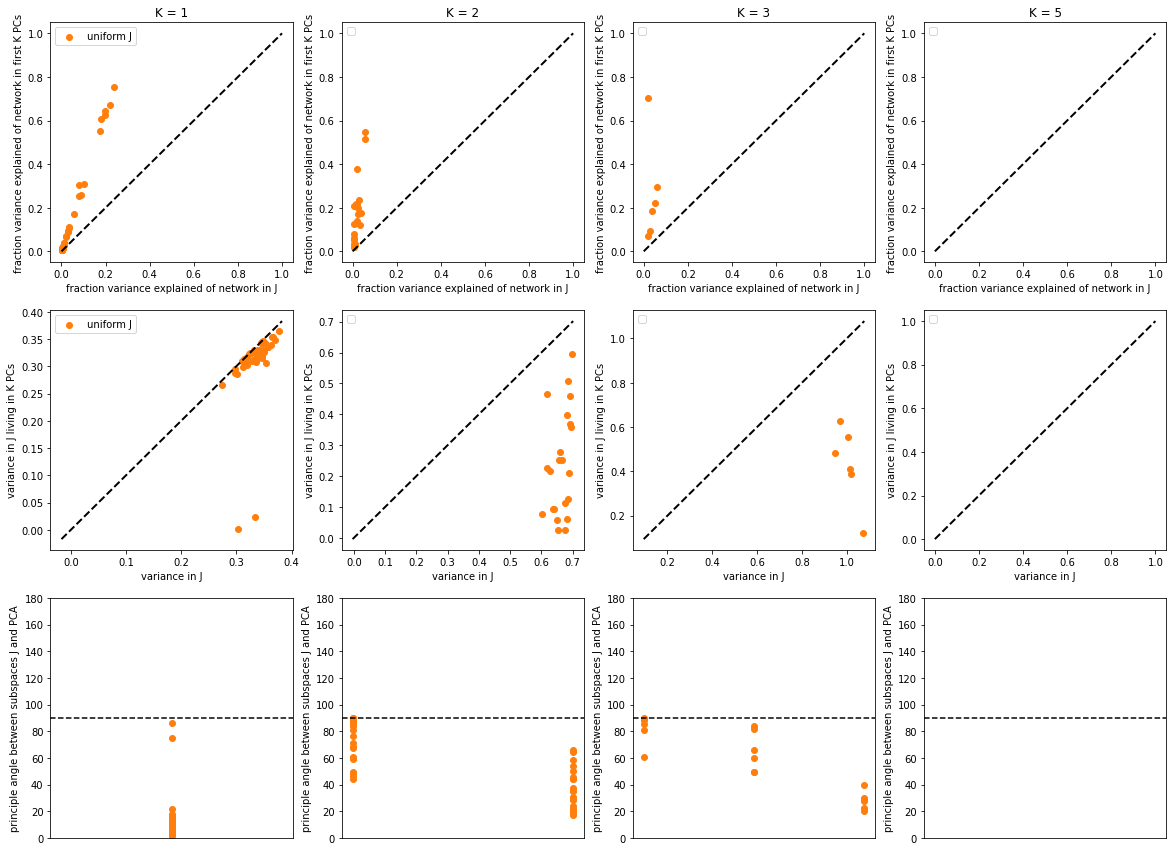

In [64]:
def PCA_misalignment_J(axes, num_simulations, K_vals, j_values):
    v = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='v')
    J = load_data(N, K_vals, j_values=j_values, num_simulations=num_simulations, parameter='J')

    for k in range(len(K_vals)):
        print(k)
        for simulation in range(num_simulations):
            for j in range(len(j_values)):
                
                if v[k,j,simulation].shape[0] == 1:
                    continue
                # PCA on network activity
                v_concat = v[k,j,simulation].reshape(v[k,j,simulation].shape[0] * v[k,j,simulation].shape[1], v[k,j,simulation].shape[2])
                mean = v_concat.mean(axis=0)

                #   mean-center
                v_concat = v_concat - mean

                eigval_PCA, eigvec_PCA = np.linalg.eig(v_concat.T @ v_concat) # eigvec 0 is eigvec[:,0] - columns
                idx = np.argsort(eigval_PCA)[::-1]
                eigval_PCA = eigval_PCA[idx]
                eigvec_PCA = eigvec_PCA[:,idx]

                fraction_cov_var_J, fraction_cov_var_PCA, cov_var_J_PCA = covariance_alignment(v_concat, J[k,j,simulation], eigvec_PCA[:,:K_vals[k]])
                if simulation == 0 :
                    axes[0,k].scatter(fraction_cov_var_J, fraction_cov_var_PCA, color=color_dict_j.get(j_vals[j]), label=f'{J_possibility_title[j_vals[j]]}')
                    axes[1,k].scatter(np.trace(J[k,j,simulation] @ J[k,j,simulation].T), cov_var_J_PCA, color=color_dict_j.get(j_vals[j]), label=f'{J_possibility_title[j_vals[j]]}')
                else:
                    axes[0,k].scatter(fraction_cov_var_J, fraction_cov_var_PCA, color=color_dict_j.get(j_vals[j]))
                    axes[1,k].scatter(np.trace(J[k,j,simulation].T @ J[k,j,simulation]), cov_var_J_PCA, color=color_dict_j.get(j_vals[j]))
                axes[2,k].scatter(range(K_vals[k]), np.rad2deg(scipy.linalg.subspace_angles(J[k,j,simulation].T, eigvec_PCA[:,:K_vals[k]])), color=color_dict_j.get(j_vals[j]))
        axes[0,k].set_xlabel('fraction variance explained of network in J')
        axes[0,k].set_ylabel('fraction variance explained of network in first K PCs')
        axes[0,k].set_title(f'K = {K_vals[k]}')
        axes[0,k].legend()
        axes[1,k].legend()
        axes[1,k].set_xlabel('variance in J')
        axes[1,k].set_ylabel('variance in J living in K PCs')
        axes[2,k].set_ylim(0,180)
        axes[2,k].set_xticks([],[])
        axes[2,k].axhline(90, linestyle='dashed',color='black')
        axes[2,k].set_ylabel('principle angle between subspaces J and PCA')
        x = np.linspace(0, 1, 100)
        y = x  # Diagonal y = x

        # Plot with dashed linestyle
        axes[0,k].plot(x, y, linestyle='--', color='black', linewidth=2)

        # Get current axis limits
        x_min, x_max = axes[1,k].get_xlim()
        y_min, y_max = axes[1,k].get_ylim()

        # Ensure the line spans the plot fully
        start = min(x_min, y_min)
        end = max(x_max, y_max)

        # Plot the diagonal line
        axes[1,k].plot([start, end], [start, end], linestyle='--', color='black', linewidth=2)

fig, axes = plt.subplots(3, len(K_vals), figsize=(5 * len(K_vals), 15))
PCA_misalignment_J(axes, num_simulations, K_vals=K_values, j_values=j_vals)
